<a href="https://colab.research.google.com/github/SayaliDeodikar/PCOS_Detection_System/blob/main/final_model_vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import cv2
import os

In [ ]:
data_dir = "/kaggle/input/clean-data/content/data/train"
CATEGORIES = ['infected', 'notinfected']
IMG_SIZE = 224

In [ ]:
training_data = []
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(data_dir, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array,(IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                print(e)
create_training_data()

In [ ]:
# training_data

In [ ]:
import random 
random.shuffle(training_data)

In [ ]:
X = []
Y = []

for categories, label in training_data:
    X.append(categories)
    Y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [ ]:
X.shape

(1924, 224, 224, 3)

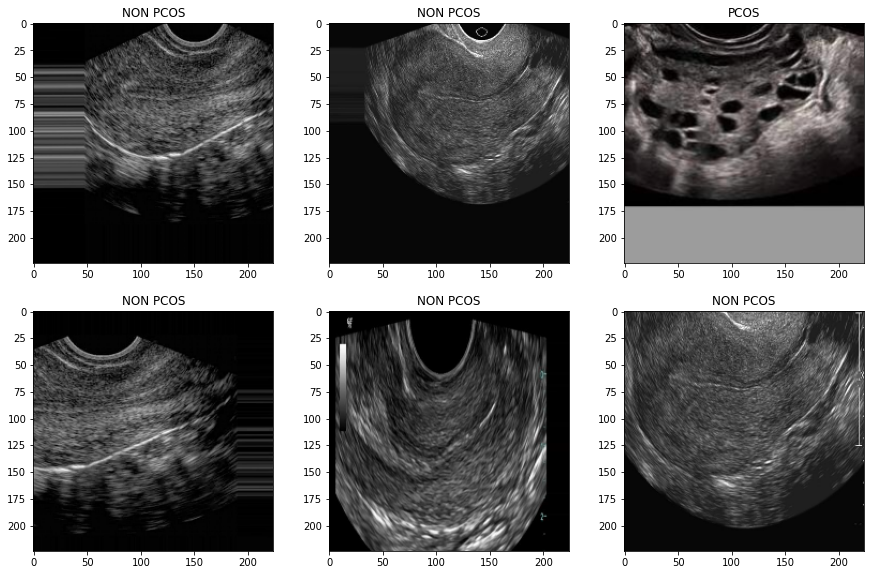

In [ ]:
plt.figure(figsize = (15, 15))
for i in range(1,7):
    plt.subplot(3,3,i)
    X1 = X.reshape(X.shape[0], IMG_SIZE, IMG_SIZE, 3)
    plt.imshow(X1[i])
    plt.title("NON PCOS") if Y[i] == 1 else plt.title("PCOS")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = (Y))

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, stratify = (Y_train))

In [ ]:
X_train = np.asarray(X_train, dtype=np.float32)
Y_train = np.asarray(Y_train, dtype=np.float32)

X_test = np.asarray(X_test, dtype=np.float32)
Y_test = np.asarray(Y_test, dtype=np.float32)

X_val = np.asarray(X_val, dtype=np.float32)
Y_val = np.asarray(Y_val, dtype=np.float32)

In [ ]:
unique, counts = np.unique(Y_train, return_counts = True)
print("The train categories distribution is:\n", dict(zip(unique, counts)))
unique, counts = np.unique(Y_test, return_counts = True)
print("The test categories distribution is:\n", dict(zip(unique, counts)))
unique, counts = np.unique(Y_val, return_counts = True)
print("The val categories distribution is:\n", dict(zip(unique, counts)))

The train categories distribution is:
 {0.0: 500, 1.0: 731}
The test categories distribution is:
 {0.0: 156, 1.0: 229}
The val categories distribution is:
 {0.0: 125, 1.0: 183}


In [ ]:
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
Y_test = to_categorical(Y_test)

In [ ]:
#Dimension of the dataset
print("Train set:\n",(X_train.shape,Y_train.shape))
print("Validation set:\n",(X_val.shape,Y_val.shape))
print("Test set:\n",(X_test.shape,Y_test.shape))

Train set:
 ((1231, 224, 224, 3), (1231, 2))
Validation set:
 ((308, 224, 224, 3), (308, 2))
Test set:
 ((385, 224, 224, 3), (385, 2))


In [ ]:
train_generator = ImageDataGenerator(rotation_range=5,
                                     horizontal_flip=True,
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     shear_range=0.5,
                                     zoom_range=0.5,
                                    fill_mode='nearest'
                                    )

In [ ]:
train_generator.fit(X_train)

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Dropout,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.optimizers import Adam
import tensorflow

In [ ]:
IMG_SHAPE = X_train[0].shape
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = IMG_SHAPE)
base_model.trainable = False

2022-11-23 14:42:57.002084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 14:42:57.176655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 14:42:57.177428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 14:42:57.179133: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
model= Sequential()
model.add(Rescaling(1./255,input_shape = IMG_SHAPE))
model.add(base_model)
model.add(Flatten())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
Total params: 20,024,384
Trainable params: 0
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.add(Dense(32,activation=('relu')))
model.add(Dropout(.5))

# final layer
model.add(Dense(2,activation=('softmax')))

# Sanity check
print(f"\nModel input shape:\n{model.input_shape}\nModel output shape:\n"\
f"{model.output_shape}\n\n\nModel summary:") 
model.summary()


Model input shape:
(None, 224, 224, 3)
Model output shape:
(None, 2)


Model summary:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                802848    
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 20,827,298
Trainable 

In [ ]:
#Initializing the hyperparameters
batch_size= 16
initial_epochs=15
learn_rate=0.0001
adam = Adam(learning_rate=learn_rate)

model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator.flow(X_train, Y_train, batch_size= batch_size),
                    epochs=initial_epochs,
                    validation_data=(X_val,Y_val),
                    steps_per_epoch=10,
                    validation_steps=len(X_val),
                    verbose = 1)

2022-11-23 14:43:11.015418: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-11-23 14:43:12.668700: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


10/10 [==============================] - 14s 609ms/step - loss: 0.7387 - accuracy: 0.5472 - val_loss: 0.6374 - val_accuracy: 0.6883
Epoch 2/15
10/10 [==============================] - 4s 464ms/step - loss: 0.6483 - accuracy: 0.6415 - val_loss: 0.5394 - val_accuracy: 0.6299
Epoch 3/15
10/10 [==============================] - 4s 389ms/step - loss: 0.6005 - accuracy: 0.6438 - val_loss: 0.4916 - val_accuracy: 0.8669
Epoch 4/15
10/10 [==============================] - 4s 378ms/step - loss: 0.5619 - accuracy: 0.7125 - val_loss: 0.4256 - val_accuracy: 0.9610
Epoch 5/15
10/10 [==============================] - 4s 431ms/step - loss: 0.5640 - accuracy: 0.7500 - val_loss: 0.4105 - val_accuracy: 0.9838
Epoch 6/15
10/10 [==============================] - 4s 388ms/step - loss: 0.4803 - accuracy: 0.7812 - val_loss: 0.3166 - val_accuracy: 0.9838
Epoch 7/15
10/10 [==============================] - 4s 460ms/step - loss: 0.4639 - accuracy: 0.8062 - val_loss: 0.2924 - val_accuracy: 0.9935
Epoch 8/15
10/10

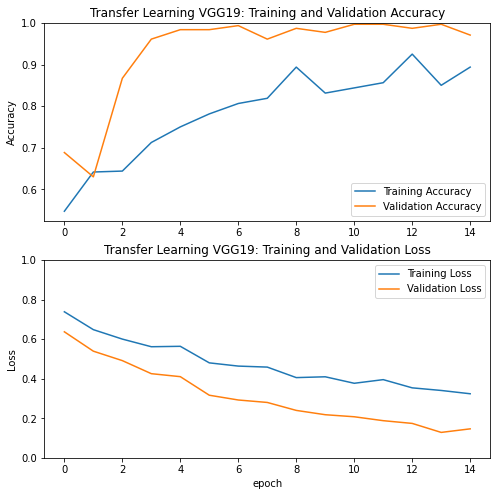

25/25 [==============================] - 1s 40ms/step - loss: 0.1535 - accuracy: 0.9740
Model accuracy on test set: 97.39999999999999%


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Transfer Learning VGG19: Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Transfer Learning VGG19: Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

_ , accuracy = model.evaluate(x=X_test,y=Y_test,batch_size= batch_size,verbose=1)
print(f'Model accuracy on test set: {round(accuracy,3)*100}%')

In [ ]:
model.save("PCOS_VGG19.h5")

In [ ]:
saved_model = tensorflow.keras.models.load_model("/kaggle/working/PCOS_VGG19.h5")

In [ ]:
saved_model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
Temporary_dataset = ["/kaggle/input/clean-data/content/data/test/infected/img_0_1387.jpg",
                    "/kaggle/input/clean-data/content/data/test/infected/img_0_1600.jpg",
                    "/kaggle/input/clean-data/content/data/test/infected/img_0_1725.jpg",
                    "/kaggle/input/clean-data/content/data/test/notinfected/img_0_1194.jpg",
                    "/kaggle/input/clean-data/content/data/test/notinfected/img_0_1552.jpg",
                    "/kaggle/input/clean-data/content/data/test/notinfected/img_0_1614.jpg"]

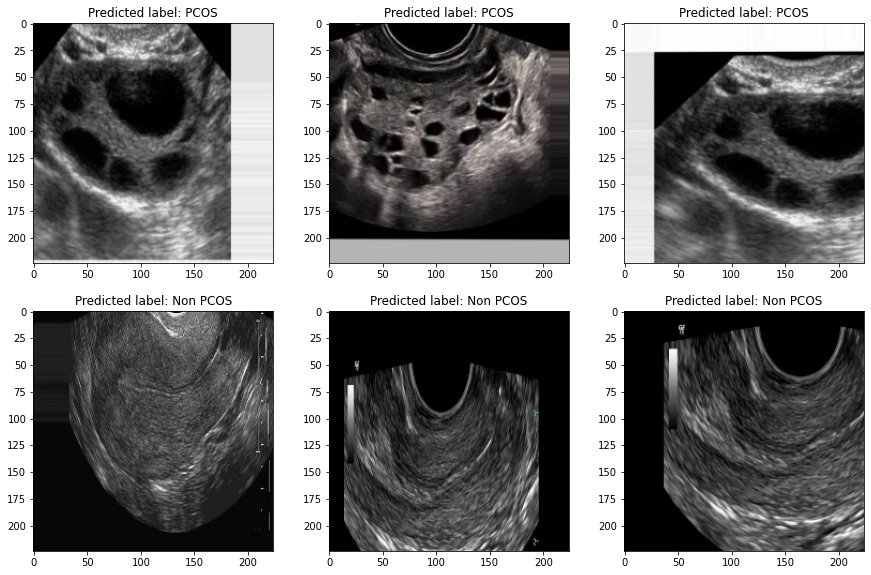

In [ ]:
IMAGE_SIZE = (224, 224)
plt.figure(figsize=(15,15))
for i in enumerate(Temporary_dataset, 1):
    plt.subplot(3,3,i[0])
    img = cv2.imread(i[1])
    img = cv2.resize(img, IMAGE_SIZE)
    plt.imshow(img)
    img = img[np.newaxis, :]
    prediction = saved_model.predict(img)
    if np.argmax(prediction) == 0:
        plt.title("Predicted label: PCOS")
    else:
        plt.title("Predicted label: Non PCOS")
plt.show()